# Segmentação e reconhecimento de células em exames de Papanicolau

### Componentes do grupo: Rafael Lopes Murta

## Importações

In [1]:
import cv2
import pandas as pd
import numpy as np
from PIL import Image
from os import listdir, makedirs
from os.path import isfile, join, exists
import matplotlib.pyplot as plt

In [2]:
classifications_csv = pd.read_csv('classifications.csv')

## Visualizações

In [3]:
classifications_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11534 entries, 0 to 11533
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_id         11534 non-null  int64 
 1   image_filename   11534 non-null  object
 2   image_doi        11534 non-null  object
 3   cell_id          11534 non-null  int64 
 4   bethesda_system  11534 non-null  object
 5   nucleus_x        11534 non-null  int64 
 6   nucleus_y        11534 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 630.9+ KB


In [4]:
classifications_csv.head()

,image_id,image_filename,image_doi,cell_id,bethesda_system,nucleus_x,nucleus_y
0,400,9ae8a4edde40219bad6303cebc672ee4.png,10.6084/m9.figshare.12230906,1,SCC,792,462
1,400,9ae8a4edde40219bad6303cebc672ee4.png,10.6084/m9.figshare.12230906,2,SCC,601,678
2,400,9ae8a4edde40219bad6303cebc672ee4.png,10.6084/m9.figshare.12230906,3,SCC,363,467
3,400,9ae8a4edde40219bad6303cebc672ee4.png,10.6084/m9.figshare.12230906,4,SCC,599,437
4,400,9ae8a4edde40219bad6303cebc672ee4.png,10.6084/m9.figshare.12230906,5,Negative for intraepithelial lesion,1186,450


In [5]:
classifications_csv['bethesda_system'].drop_duplicates()

0                                     SCC
4     Negative for intraepithelial lesion
6                                    LSIL
8                                    HSIL
9                                   ASC-H
98                                 ASC-US
Name: bethesda_system, dtype: object

## Funções

In [6]:
# Corta a imagem no tamanho de 100x100 pixels
def crop_image(image, x, y):
    width, height = image.size
    if(x < 50):
        left = 0
        right = 100
    elif(x > width - 50):
        left = width - 100
        right = width
    else:
        left = x - 50
        right = x + 50
    if (y < 50):
        top = 0
        bottom = 100
    elif(y > height - 50):
        top = height - 100
        bottom = height
    else:
        top = y - 50
        bottom = y + 50
    image = image.crop((left, top, right, bottom))
    return image

In [7]:
def get_img_dir(bethesda_system):
    if bethesda_system == 'SCC' or bethesda_system == 'LSIL' or bethesda_system == 'HSIL' or bethesda_system == 'ASC-H' or bethesda_system == 'ASC-US':
        return 'editted_images/' + bethesda_system.lower() + '/'
    elif bethesda_system == 'Negative for intraepithelial lesion':
        return 'editted_images/nfil/'


In [8]:
def get_new_nucleus_position(image, x, y):
    width, height = image.size
    if (x >= 50 and x <= (width - 50)):
        new_x = 50
    elif (x < 50):
        new_x = x
    else:
        new_x = 50 + (width - x)

    if (y >= 50 and y <= (height - 50)):
        new_y = 50
    elif (y < 50):
        new_y = y
    else:
        new_y = 50 + (height - y)
    
    return new_x, new_y

In [9]:
def process_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    kernel = np.ones((10, 10), np.uint8)
    return cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

In [10]:
def get_shape_descriptors(image):
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contour = contours[0]
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        if area > 0:
            compactness = (perimeter**2) / (4 * np.pi * area)
            moments = cv2.moments(contour)
            hu_moments = cv2.HuMoments(moments).flatten()
            rect = cv2.minAreaRect(contour)
            axis_x = rect[1][0]
            axis_y = rect[1][1]

            if axis_x > axis_y:
                eccentricity = axis_x / axis_y
            else:
                eccentricity = axis_y / axis_x

            return [area, perimeter, compactness, hu_moments, eccentricity]
        
    return None


## Salvar as imagens nas respectivas pastas

In [11]:
dir_list = ['scc', 'lsil', 'hsil', 'asc-h', 'asc-us', 'nfil']
makedirs('editted_images', exist_ok=True)
for i in dir_list:
    makedirs(f'editted_images/{i}', exist_ok=True)
dataframe = pd.DataFrame(columns=['original_filename', 'cell_id', 'bethesda_system', 'nucleus_x', 'nucleus_y', 'area', 'perimeter', 'compactness', 'hu_moments', 'eccentricity'])
onlyfiles = [f for f in listdir('images') if isfile(join('images', f))]
for index, row in classifications_csv.iterrows():
    if row["image_filename"] in onlyfiles:
        original_image_filepath = f'images/{row["image_filename"]}'
        image = Image.open(original_image_filepath)
        croped_image = crop_image(image, row['nucleus_x'], row['nucleus_y'])
        croped_image_filepath = f'{get_img_dir(row["bethesda_system"])}{row["cell_id"]}.jpg'
        croped_image.save(croped_image_filepath)

        x, y = get_new_nucleus_position(image, row['nucleus_x'], row['nucleus_y'])

        processed_image = process_image(np.array(croped_image))

        processed_image_shape_descriptors = get_shape_descriptors(processed_image)

        if(processed_image_shape_descriptors):
            area = processed_image_shape_descriptors[0]
            perimeter = processed_image_shape_descriptors[1]
            compactness = processed_image_shape_descriptors[2]
            hu_moments = processed_image_shape_descriptors[3]
            eccentricity = processed_image_shape_descriptors[4]

            dataframe.loc[dataframe.size] = [original_image_filepath, row['cell_id'], row['bethesda_system'], x, y, area, perimeter, compactness, hu_moments, eccentricity]
        else:
            dataframe.loc[dataframe.size] = [original_image_filepath, row['cell_id'], row['bethesda_system'], x, y, '', '', '', '', '']
dataframe.to_csv('preprocessed_data.csv', index=False)

## Segmentar as Imagens

In [12]:
def distance_between_points(point_a, point_b):
    return np.sqrt((point_a[0] - point_b[0]) ** 2 + (point_a[1] - point_b[1]) ** 2)

1.jpg --> 50.774009099144415 pixels de distância
2.jpg --> 1.4142135623730951 pixels de distância
3.jpg --> 2.23606797749979 pixels de distância
4.jpg --> 7.0710678118654755 pixels de distância
5.jpg --> 36.87817782917155 pixels de distância
6.jpg --> 7.211102550927978 pixels de distância
7.jpg --> 3.1622776601683795 pixels de distância
8.jpg --> 10.63014581273465 pixels de distância
9.jpg --> 26.30589287593181 pixels de distância
10.jpg --> 21.540659228538015 pixels de distância
11.jpg --> 29.154759474226502 pixels de distância
12.jpg --> 29.068883707497267 pixels de distância
13.jpg --> 42.2965719651132 pixels de distância
14.jpg --> 33.61547262794322 pixels de distância
15.jpg --> 12.206555615733702 pixels de distância
16.jpg --> 30.463092423455635 pixels de distância
17.jpg --> 23.021728866442675 pixels de distância
18.jpg --> 39.6232255123179 pixels de distância
19.jpg --> 37.21558813185679 pixels de distância
20.jpg --> 48.02082881417188 pixels de distância
21.jpg --> 41.0 pixels

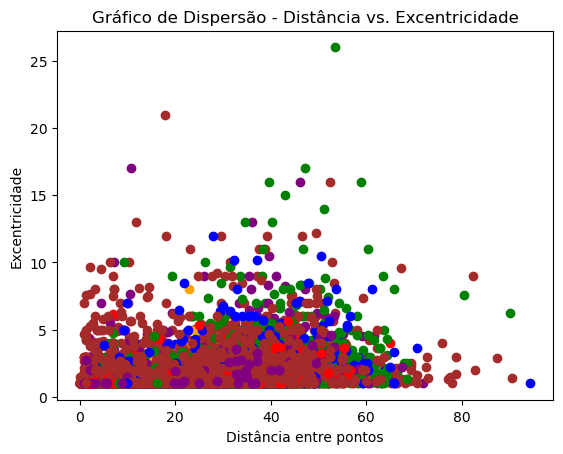

In [13]:
makedirs('segmented_images', exist_ok=True)
preprocessed_data_csv = pd.read_csv('preprocessed_data.csv')
class_colors = {'ASC-H': 'blue', 'ASC-US': 'red', 'HSIL': 'green', 'LSIL': 'purple', 'SCC': 'orange', 'Negative for intraepithelial lesion': 'brown'}

for index, row in preprocessed_data_csv.iterrows():
    filename = f'{row["cell_id"]}.jpg'
    filepath = f'{get_img_dir(row["bethesda_system"])}{filename}'
    if (exists(filepath)):
        image = cv2.imread(filepath)
        
        cell_id = row['cell_id']
        bethesda_system = row['bethesda_system']
        nucleus_x = int(row['nucleus_x'])
        nucleus_y = int(row['nucleus_y'])

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            center = cv2.moments(largest_contour)

            if center["m00"] != 0:
                center_x = int(center["m10"] / center["m00"])
                center_y = int(center["m01"] / center["m00"])

                segmented_nucleus = (center_x, center_y)

                segmented_image = image.copy()
                cv2.drawContours(segmented_image, [largest_contour], -1, (0, 255, 0), 2)
                    
                new_path = f'segmented_images/{filename}'
                cv2.imwrite(new_path, segmented_image)

                dist = distance_between_points((center_x, center_y), (nucleus_x, nucleus_y))
                print(f"{filename} --> {dist} pixels de distância")
                plt.scatter(dist, # x: distância
                            row['eccentricity'], # y: excentricidade
                            color=class_colors.get(row['bethesda_system'], 'gray'),
                            label=row['bethesda_system'])
                
# Adicionando rótulos e título ao gráfico
plt.xlabel('Distância entre pontos')
plt.ylabel('Excentricidade')
plt.title('Gráfico de Dispersão - Distância vs. Excentricidade')
# Exibindo o gráfico
plt.show()